# Data Imputation

### This notebook focuses on data imputation, outlier handling, and exploratory analysis using PySpark. 

We begin by setting up a Spark session and importing the data, followed by identifying and treating missing values. Then, we perform statistical and correlation analysis to guide feature selection. Finally, we handle outliers using IQR and z-score methods, explore hexadecimal data, and convert it for further analysis.

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
# building spark session
spark = SparkSession.builder \
    .config("spark.driver.memory", "5g") \
    .config("spark.local.dir", "spark") \
    .getOrCreate()

spark

In [3]:
spark.conf.get("spark.local.dir")

'spark'

We load the dataset from a tab-delimited file, assign meaningful column names, inspect the schema, and count the number of rows.

In [4]:
columns = ["Label", "I1", "I2", "I3", "I4", "I5", "I6", "I7", "I8", "I9", 
           "I10", "I11", "I12", "I13", "C1", "C2", "C3", "C4", "C5", "C6", 
           "C7", "C8", "C9", "C10", "C11", "C12", "C13", "C14", "C15", "C16", 
           "C17", "C18", "C19", "C20", "C21", "C22", "C23", "C24", "C25", "C26"]

df = (
    spark.read
    .option("sep", "\t") 
    .option("inferSchema", "true")  
    .csv("dac/train.txt") 
)

df = df.toDF(*columns)

# df.printSchema()

print(f"Liczba wierszy: {df.count()}")

Liczba wierszy: 45840617


We save a 2-million-row subset of the data to a Parquet file, and also save a randomized version to ensure varied data for analysis. 
                                                                                                                   
                                            

In [5]:
#df.limit(2_000_000).write.mode("overwrite").parquet("output_parquet_2mln")
#data = spark.read.parquet("output_parquet_2mln")

#df.orderBy(F.rand()) \
  # .limit(2_000_000) \
  # .repartition(100) \
  # .write.mode("overwrite") \
  # .parquet("output_parquet_randomize_2mln")

data_rand = spark.read.parquet("output_parquet_randomize_2mln")


## Null Analysis
Here we analyze the proportion of missing values (NULLs) in each column and determine which ones should be dropped or imputed.

In [6]:
from pyspark.sql.functions import col

print("Percentage of null values per column:\n")

# for data:
columns_to_imputate = []
columns_to_drop = []
number_of_rows = data.count()

# for data_rand:
columns_to_imputate_rand = []
columns_to_drop_rand = []
number_of_rows_rand = data_rand.count()


# drop columns which have 70% null values, for other missing - imputation
for column in data.columns:
    count_null = data.filter(col(column).isNull()).count()
    percentage_null = (count_null / number_of_rows) * 100
    
    count_null_rand = data_rand.filter(col(column).isNull()).count()
    percentage_null_rand = (count_null_rand / number_of_rows) * 100
    
    print(f"Column '{column}':")
    
    if percentage_null == 0:
         print(f"in data has {percentage_null:.2f}% NULL values.")
    else:
        if percentage_null <= 70:
            columns_to_imputate.append(column)
            print(f"in data has {percentage_null:.2f}% NULL values, will be imputated.")
        else:
            columns_to_drop.append(column)
            print(f"in data has {percentage_null:.2f}% NULL values, will be dropped.")
            
    if percentage_null_rand == 0:
        print(f"in randomized data has {percentage_null_rand:.2f}% NULL values.\n")
    else:
        if percentage_null_rand <= 70:
            columns_to_imputate_rand.append(column)
            print(f"in randomized data has {percentage_null_rand:.2f}% NULL values, will be imputated.\n")
        else:
            columns_to_drop_rand.append(column)
            print(f"in randomized data has {percentage_null_rand:.2f}% NULL values, will be dropped.\n")

print(f"Columns in data: \n to drop: {columns_to_drop}.\n to imputate: {columns_to_imputate}")
print(f"Columns in randomized data: \n to drop: {columns_to_drop_rand}.\n to imputate: {columns_to_imputate_rand}")

if columns_to_imputate_rand == columns_to_imputate:
    print("The same columns in both data will be imputated.") 
else:
    print("Different columns in both data will be imputated.")
    
if columns_to_drop_rand == columns_to_drop:
    print("The same columns in both data will be dropped.")
else:
    print("Different columns in both data will be dropped.")


Percentage of null values per column:

Column 'Label':
in data has 0.00% NULL values.
in randomized data has 0.00% NULL values.

Column 'I1':
in data has 42.49% NULL values, will be imputated.
in randomized data has 45.37% NULL values, will be imputated.

Column 'I2':
in data has 0.00% NULL values.
in randomized data has 0.00% NULL values.

Column 'I3':
in data has 22.72% NULL values, will be imputated.
in randomized data has 21.46% NULL values, will be imputated.

Column 'I4':
in data has 23.66% NULL values, will be imputated.
in randomized data has 21.70% NULL values, will be imputated.

Column 'I5':
in data has 2.27% NULL values, will be imputated.
in randomized data has 2.58% NULL values, will be imputated.

Column 'I6':
in data has 21.89% NULL values, will be imputated.
in randomized data has 22.36% NULL values, will be imputated.

Column 'I7':
in data has 3.99% NULL values, will be imputated.
in randomized data has 4.34% NULL values, will be imputated.

Column 'I8':
in data has 0

In [6]:
# to make it faster in later analysis:
columns_to_drop = ['I12', 'C22']
columns_to_drop_rand = ['I12', 'C22']
columns_to_imputate = ['I1', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'I10', 'I11', 'I13', 'C3', 'C4', 'C6', 'C12', 'C16', 'C19', 'C20', 'C21', 'C24', 'C25', 'C26']
columns_to_imputate_rand = ['I1', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'I10', 'I11', 'I13', 'C3', 'C4', 'C6', 'C12', 'C16', 'C19', 'C20', 'C21', 'C24', 'C25', 'C26']

## Correlation Matrix

We identify numeric columns for correlation and statistical operations.

We compute and visualize pairwise correlations among numeric features using a heatmap.



In [8]:
numeric_cols = [col_name for col_name, dtype in data_rand.dtypes if dtype in ("int", "double", "float")]

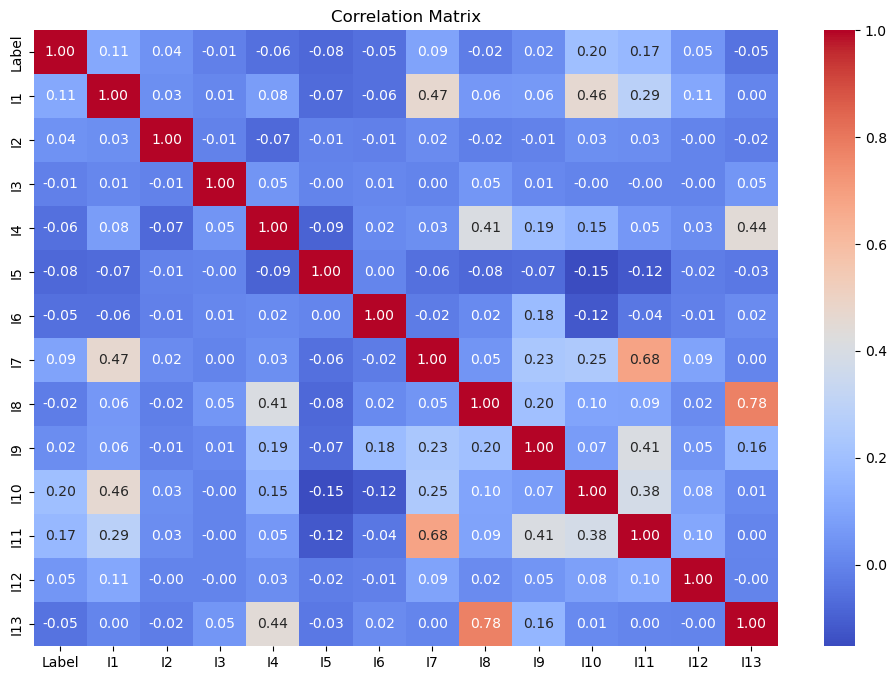

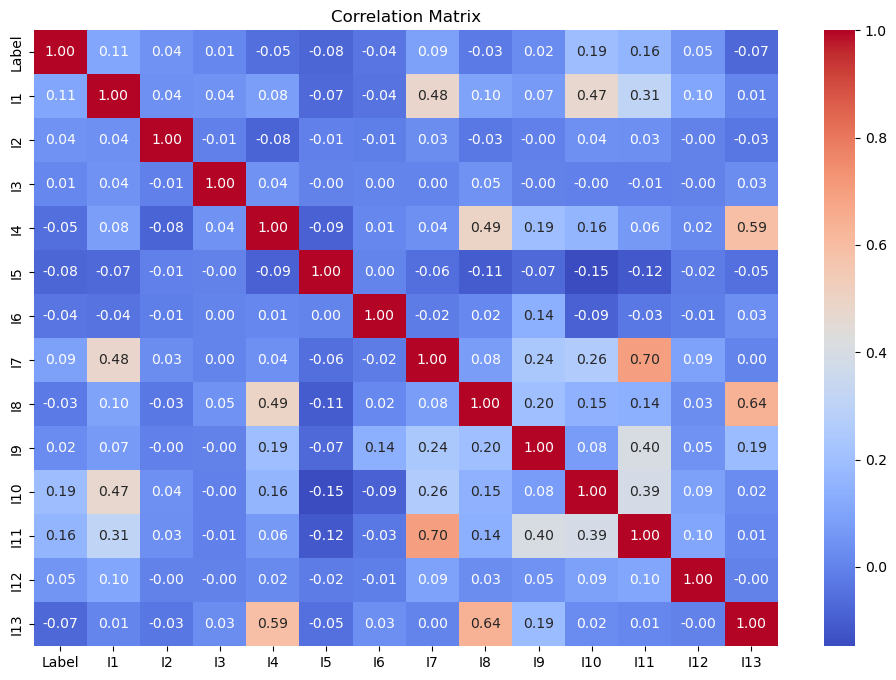

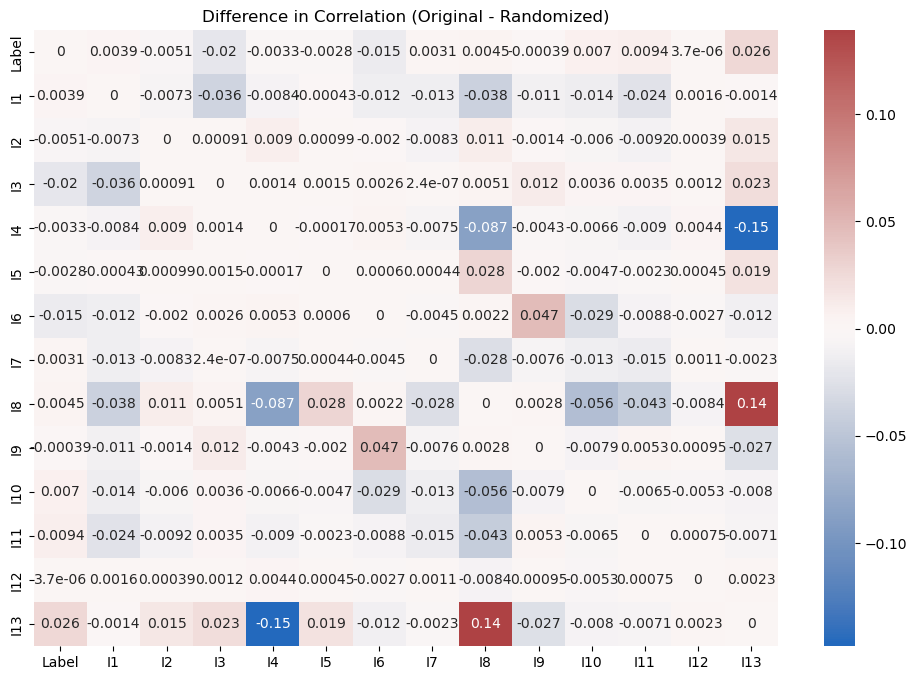

In [8]:
# correlation in our data
correlation_matrix = pd.DataFrame(columns=numeric_cols, index=numeric_cols)

for col1 in numeric_cols:
    for col2 in numeric_cols:
        correlation_matrix.loc[col1, col2] = data.stat.corr(col1, col2)  # compute correlation

correlation_matrix = correlation_matrix.astype(float)  # ensure numeric type for plotting

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# correlation in our randomized data

correlation_matrix_rand = pd.DataFrame(columns=numeric_cols, index=numeric_cols)

for col1 in numeric_cols:
    for col2 in numeric_cols:
        correlation_matrix_rand.loc[col1, col2] = data_rand.stat.corr(col1, col2)  

correlation_matrix_rand = correlation_matrix_rand.astype(float)  

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_rand, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# differences in correlations
difference_matrix = correlation_matrix - correlation_matrix_rand  
plt.figure(figsize=(12, 8))
sns.heatmap(difference_matrix, annot=True, cmap="vlag", center=0)
plt.title("Difference in Correlation (Original - Randomized)")
plt.show()

Analyzing the correlation in randomized data:

In [12]:
import pandas as pd
import numpy as np

def interpret_correlation(value):
    if value >= 0.9:
        return "very strong positive"
    elif value >= 0.8:
        return "strong positive"
    elif value >= 0.5:
        return "moderate positive"
    elif value >= 0.3:
        return "weak positive"
    elif value <= -0.9:
        return "very strong negative"
    elif value <= -0.8:
        return "strong negative"
    elif value <= -0.5:
        return "moderate negative"
    elif value <= -0.3:
        return "weak negative"
    else:
        return "very weak"

def generate_detailed_observations(corr_df, threshold=0.10):
    observations = []

    for col1 in corr_df.columns:
        for col2 in corr_df.columns:
            if col1 < col2:
                value = corr_df.loc[col1, col2]
                abs_val = abs(value)
                if abs_val >= threshold: # Only consider correlations >= 0.10
                    strength = interpret_correlation(value)
                    obs = f"{col1} and {col2} have a {strength} correlation of {value:.2f}."

                    if abs_val >= 0.9:
                        obs += " This suggests strong predictive potential."

                    if strength in ["strong negative", "very strong negative"]:
                        obs += " This strong inverse relationship may be surprising and worth investigating."

                    observations.append((abs_val, obs, col1, col2))

    observations.sort(reverse=True, key=lambda x: x[0])

    final_observations = [obs[1] for obs in observations]

    # Find the weakest correlation *above* the threshold
    min_corr = float('inf')
    min_pair = ("", "")
    for col1 in corr_df.columns:
        for col2 in corr_df.columns:
            if col1 < col2:
                val = abs(corr_df.loc[col1, col2])
                if val >= threshold and val < min_corr: # Only consider correlations >= 0.10
                    min_corr = val
                    min_pair = (col1, col2)
    if min_pair != ("", ""): #check if a pair was found
        final_observations.append(
            f"{min_pair[0]} and {min_pair[1]} have the weakest correlation above the threshold ({corr_df.loc[min_pair[0], min_pair[1]]:.2f})."
        )
    else:
        final_observations.append(f"No correlations above the threshold of {threshold}."
        )
    return final_observations


In [13]:
observations = generate_detailed_observations(correlation_matrix_rand)
for obs in observations:
    print("- " + obs)

- I11 and I7 have a moderate positive correlation of 0.70.
- I13 and I8 have a moderate positive correlation of 0.64.
- I13 and I4 have a moderate positive correlation of 0.59.
- I4 and I8 have a weak positive correlation of 0.49.
- I1 and I7 have a weak positive correlation of 0.48.
- I1 and I10 have a weak positive correlation of 0.47.
- I11 and I9 have a weak positive correlation of 0.40.
- I10 and I11 have a weak positive correlation of 0.39.
- I1 and I11 have a weak positive correlation of 0.31.
- I10 and I7 have a very weak correlation of 0.26.
- I7 and I9 have a very weak correlation of 0.24.
- I8 and I9 have a very weak correlation of 0.20.
- I4 and I9 have a very weak correlation of 0.19.
- I10 and Label have a very weak correlation of 0.19.
- I13 and I9 have a very weak correlation of 0.19.
- I11 and Label have a very weak correlation of 0.16.
- I10 and I4 have a very weak correlation of 0.16.
- I10 and I8 have a very weak correlation of 0.15.
- I10 and I5 have a very weak co

Columns I12 and C22 are highly incomplete and weakly correlated - thus they will be dropped. 

Columns like I3, I8, I9 also show weak correlations, so they will be dropped.

I10, I11 have the strongest correlation with the target label.

We calculate min, max, average, and standard deviation for all numeric columns and visualize them in styled tables for better readability.

In [15]:
from IPython.display import display

stat_list = []
for col in numeric_cols:
    stat_list.append(F.min(col).alias(f"{col}_min"))
    stat_list.append(F.max(col).alias(f"{col}_max"))
    stat_list.append(F.avg(col).alias(f"{col}_avg"))
    stat_list.append(F.stddev(col).alias(f"{col}_std"))

summary_stats = data_rand.select(*stat_list)

summary_stats_pandas = summary_stats.toPandas()

third_len = len(summary_stats_pandas.columns) // 3

df_part1 = summary_stats_pandas.iloc[:, :third_len]  
df_part2 = summary_stats_pandas.iloc[:, third_len:2*third_len]  
df_part3 = summary_stats_pandas.iloc[:, 2*third_len:]  

styled_part1 = df_part1.style \
    .highlight_max(color='lightgreen') \
    .highlight_min(color='salmon') \
    .set_properties(**{'text-align': 'center'})

styled_part2 = df_part2.style \
    .highlight_max(color='lightgreen') \
    .highlight_min(color='salmon') \
    .set_properties(**{'text-align': 'center'})

styled_part3 = df_part3.style \
    .highlight_max(color='lightgreen') \
    .highlight_min(color='salmon') \
    .set_properties(**{'text-align': 'center'})

display(styled_part1)  
display(styled_part2)  
display(styled_part3)


,Label_min,Label_max,Label_avg,Label_std,I1_min,I1_max,I1_avg,I1_std,I2_min,I2_max,I2_avg,I2_std,I3_min,I3_max,I3_avg,I3_std,I4_min,I4_max
0,0,1,0.256182,0.436524,0,1539,3.496802,9.199950,-2,22247,106.054928,390.304483,0,65535,27.153454,404.843594,0,704


,I4_avg,I4_std,I5_min,I5_max,I5_avg,I5_std,I6_min,I6_max,I6_avg,I6_std,I7_min,I7_max,I7_avg,I7_std,I8_min,I8_max,I8_avg,I8_std
0,7.318059,8.777901,0,2495496,18531.529889,69413.428663,0,367553,116.297592,535.362961,0,7624,16.320118,64.341783,0,4948,12.507138,17.111480


,I9_min,I9_max,I9_avg,I9_std,I10_min,I10_max,I10_avg,I10_std,I11_min,I11_max,I11_avg,I11_std,I12_min,I12_max,I12_avg,I12_std,I13_min,I13_max,I13_avg,I13_std
0,0,20196,106.083407,221.585049,0,9,0.617475,0.683824,0,144,2.734091,5.192436,0,827,0.997764,5.400104,0,5934,8.220410,16.769329


## Exploratory Data Analysis

Beginning exploratory data analysis and preparing for imputation.

From now on, we use randomized data to our analysis.

First, we clean the dataset by removing heavily null columns and rows with all values missing.

In [9]:
columns_to_drop_all = columns_to_drop_rand + ['I3', 'I8', 'I9']
data_cleaned = data_rand.drop(*columns_to_drop_all)
data_cleaned = data_cleaned.na.drop(how="all")
print(data_cleaned.columns)


['Label', 'I1', 'I2', 'I4', 'I5', 'I6', 'I7', 'I10', 'I11', 'I13', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C23', 'C24', 'C25', 'C26']


We visualize boxplots for each numeric column to examine distributions and detect outliers.



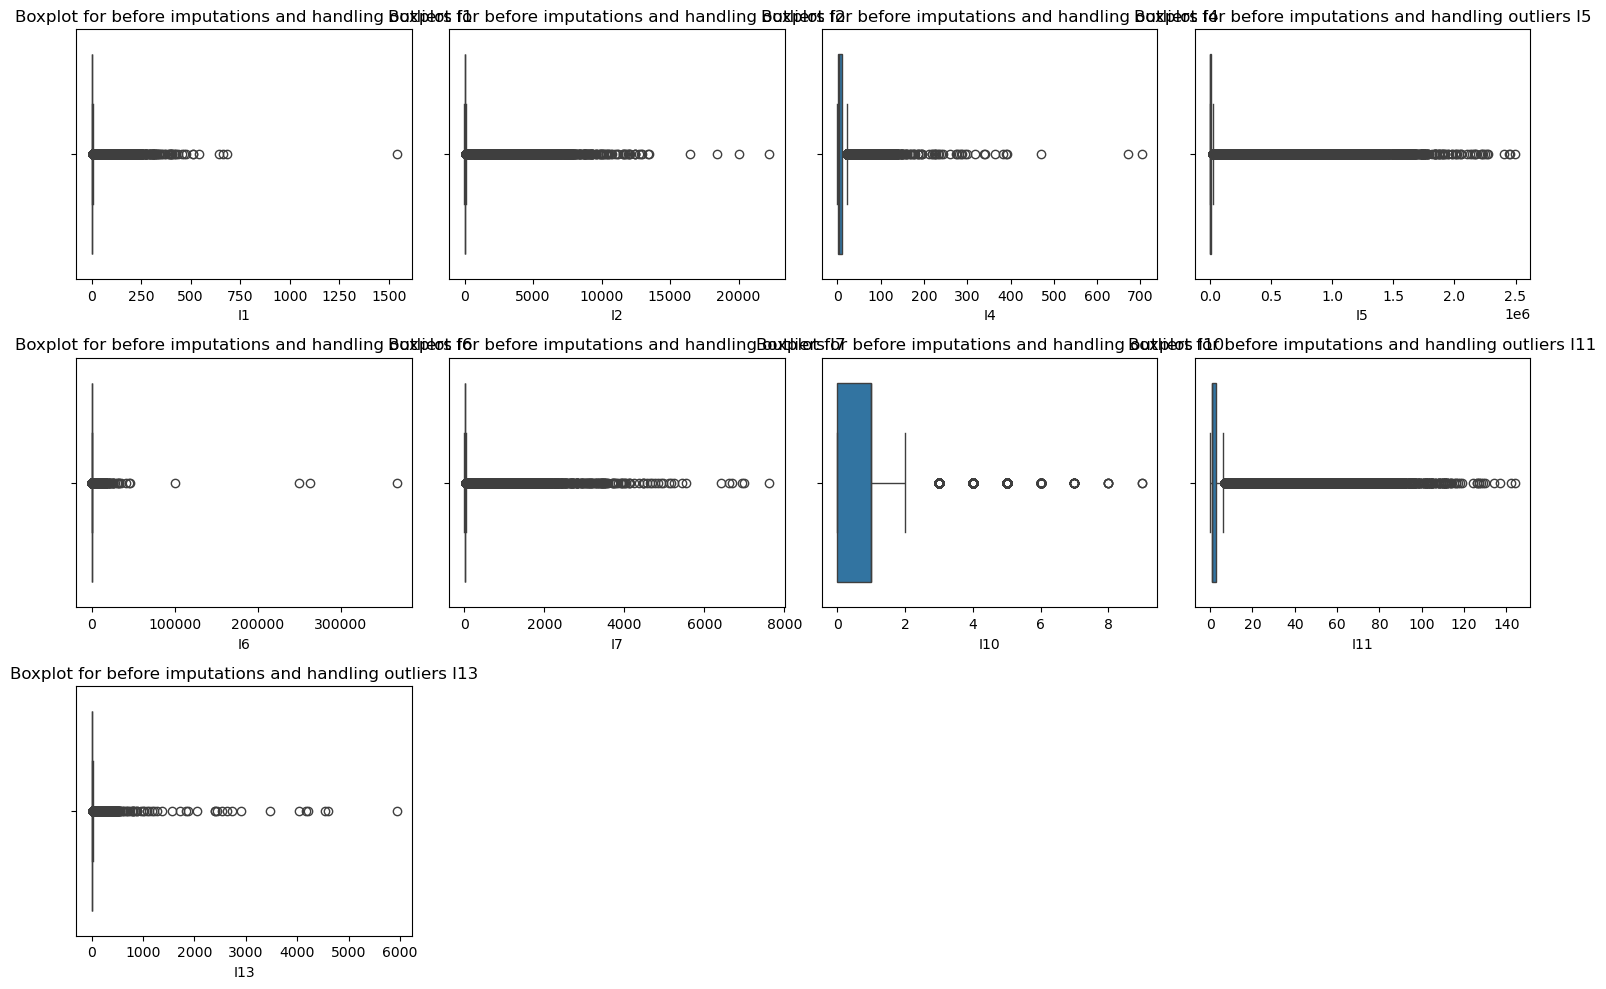

In [10]:
numeric_cols = [col for col in data_cleaned.columns if col.startswith('I')]

data_sample = data_cleaned.select(numeric_cols).limit(2000000).toPandas()

plt.figure(figsize=(15, 10))

for i, col in enumerate(numeric_cols):
    plt.subplot(len(numeric_cols)//4 + 1, 4, i + 1) 
    sns.boxplot(data=data_sample, x=col, orient="h")
    plt.title(f"Boxplot for before imputations and handling outliers {col}")

plt.tight_layout()
plt.show()


In [ ]:
We can observe, that column I10 is probably integer and we will skip it in handling outliers

In [11]:
def report_outliers_dual(df, numeric_cols, z_thresh=3.0, iqr_multiplier=1.5):
    from pyspark.sql import functions as F

    print("\n--- Outlier Summary (IQR vs Z-Score) ---")
    print(f"{'Column':<10} | {'IQR Outliers (%)':>18} | {'Z-Score Outliers (%)':>23}")
    print("-" * 60)

    for col in numeric_cols:
        stats = df.selectExpr(
            f'percentile({col}, array(0.25, 0.5, 0.75)) as percentiles',
            f'mean({col}) as mean',
            f'stddev({col}) as stddev'
        ).first()

        q1, _, q3 = stats['percentiles']
        mean, stddev = stats['mean'], stats['stddev']
        iqr = q3 - q1

        # IQR bounds
        lower_iqr = q1 - iqr_multiplier * iqr
        upper_iqr = q3 + iqr_multiplier * iqr

        # Z-score bounds
        lower_z = mean - z_thresh * stddev
        upper_z = mean + z_thresh * stddev

        # Count total non-null entries
        total_count = df.filter(F.col(col).isNotNull()).count()

        # Count outliers
        iqr_outliers = df.filter((F.col(col) < lower_iqr) | (F.col(col) > upper_iqr)).count()
        zscore_outliers = df.filter((F.col(col) < lower_z) | (F.col(col) > upper_z)).count()

        iqr_ratio = (iqr_outliers / total_count) * 100 if total_count else 0
        zscore_ratio = (zscore_outliers / total_count) * 100 if total_count else 0

        print(f"{col:<10} | {iqr_ratio:>17.2f}% | {zscore_ratio:>22.2f}%")


In [12]:
from pyspark.sql import functions as F
from IPython.display import display

def handle_outliers(df, numeric_cols, method="iqr", action="cap", z_thresh=3.0, iqr_multiplier=1.5, threshold_ratio=0.2):
    updated_df = df

    for col in numeric_cols:
        stats = df.selectExpr(
            f'percentile({col}, array(0.25, 0.5, 0.75)) as percentiles',
            f'mean({col}) as mean',
            f'stddev({col}) as stddev'
        ).first()

        q1, median, q3 = stats['percentiles']
        mean, stddev = stats['mean'], stats['stddev']
        iqr = q3 - q1
        lower_iqr, upper_iqr = q1 - iqr_multiplier * iqr, q3 + iqr_multiplier * iqr
        lower_z, upper_z = mean - z_thresh * stddev, mean + z_thresh * stddev

        lower, upper = (lower_iqr, upper_iqr) if method == "iqr" else (lower_z, upper_z)

        total_count = df.filter(F.col(col).isNotNull()).count()
        outlier_count = df.filter((F.col(col) < lower) | (F.col(col) > upper)).count()
        outlier_ratio = outlier_count / total_count if total_count else 0

        if outlier_ratio == 0:
            continue

        if outlier_ratio > threshold_ratio:
            print(f"Skipping {col} due to high outlier ratio.")
            continue

        if action == "remove":
            updated_df = updated_df.filter((F.col(col) >= lower) & (F.col(col) <= upper))
        elif action == "impute":
            updated_df = updated_df.withColumn(
                col,
                F.when((F.col(col) < lower) | (F.col(col) > upper), median).otherwise(F.col(col))
            )
        elif action == "cap":
            updated_df = updated_df.withColumn(
                col,
                F.when(F.col(col) < lower, lower)
                 .when(F.col(col) > upper, upper)
                 .otherwise(F.col(col))
            )
        else:
            raise ValueError("Invalid action: choose from 'cap', 'remove', 'impute'.")

    return updated_df


In [15]:
def display_summary(df, title="Statistics"):
    print(f"\n{title}:\n")
    stat_list = []
    for col in numeric_cols:
        stat_list.append(F.min(col).alias(f"{col}_min"))
        stat_list.append(F.max(col).alias(f"{col}_max"))
        stat_list.append(F.avg(col).alias(f"{col}_avg"))
        stat_list.append(F.stddev(col).alias(f"{col}_std"))

    summary_stats = df.select(*stat_list).toPandas()

    third_len = len(summary_stats.columns) // 3
    df_part1 = summary_stats.iloc[:, :third_len]
    df_part2 = summary_stats.iloc[:, third_len:2*third_len]
    df_part3 = summary_stats.iloc[:, 2*third_len:]

    display(df_part1.style.highlight_max(color='lightgreen').highlight_min(color='salmon').set_properties(**{'text-align': 'center'}))
    display(df_part2.style.highlight_max(color='lightgreen').highlight_min(color='salmon').set_properties(**{'text-align': 'center'}))
    display(df_part3.style.highlight_max(color='lightgreen').highlight_min(color='salmon').set_properties(**{'text-align': 'center'}))


In [16]:
def generate_outlier_handling_datasets(df, numeric_cols):
    methods = ["iqr", "z-score"]
    actions = ["cap", "remove", "impute"]

    results = {}
    
    for method in methods:
        for action in actions:
            print(f"\nMethod: {method.upper()}, Action: {action.upper()}")
            handled_df = handle_outliers(
                df=df,
                numeric_cols=numeric_cols,
                method=method,
                action=action,
                z_thresh=3.0,
                iqr_multiplier=1.5,
                threshold_ratio=0.2
            )
            label = f"{method}_{action}"
            results[label] = handled_df
            display_summary(handled_df, f"After Outlier Handling - Method: {method.upper()}, Action: {action.upper()}")

    return results


In [18]:
numeric_cols = ['I1', 'I2', 'I4', 'I5', 'I6', 'I7', 'I11', 'I13']
report_outliers_dual(data_cleaned, numeric_cols)

all_outlier_handled_datasets = generate_outlier_handling_datasets(data_cleaned, numeric_cols)



--- Outlier Summary (IQR vs Z-Score) ---
Column     |   IQR Outliers (%) |    Z-Score Outliers (%)
------------------------------------------------------------
I1         |             12.04% |                   1.49%
I2         |             15.95% |                   2.23%
I4         |              6.58% |                   2.21%
I5         |             13.21% |                   1.77%
I6         |             11.34% |                   0.56%
I7         |             12.69% |                   1.05%
I11        |              9.62% |                   1.96%
I13        |              8.45% |                   0.57%

Method: IQR, Action: CAP

After Outlier Handling - Method: IQR, Action: CAP:



,I1_min,I1_max,I1_avg,I1_std,I2_min,I2_max,I2_avg,I2_std,I4_min,I4_max
0,0.000000,7.500000,2.083446,2.631998,-2.000000,87.500000,22.594750,32.843728,0.000000,22.000000


,I4_avg,I4_std,I5_min,I5_max,I5_avg,I5_std,I6_min,I6_max,I6_avg,I6_std
0,6.643346,6.472128,0.000000,24868.000000,6948.574480,8650.499716,0.000000,243.000000,69.416111,81.190505


,I7_min,I7_max,I7_avg,I7_std,I11_min,I11_max,I11_avg,I11_std,I13_min,I13_max,I13_avg,I13_std
0,0.000000,26.000000,7.511933,9.029267,0.000000,6.000000,1.920496,1.927964,0.000000,22.000000,6.942439,6.815366



Method: IQR, Action: REMOVE

After Outlier Handling - Method: IQR, Action: REMOVE:



,I1_min,I1_max,I1_avg,I1_std,I2_min,I2_max,I2_avg,I2_std,I4_min,I4_max
0,0,7,1.507237,1.804513,-2,87,11.786315,19.056258,0,22


,I4_avg,I4_std,I5_min,I5_max,I5_avg,I5_std,I6_min,I6_max,I6_avg,I6_std
0,5.999256,5.333047,0,24861,1608.837407,2444.028556,0,243,42.999856,54.128798


,I7_min,I7_max,I7_avg,I7_std,I11_min,I11_max,I11_avg,I11_std,I13_min,I13_max,I13_avg,I13_std
0,0,26,5.710059,5.464223,0,6,1.961300,1.312942,0,22,5.944746,5.462269



Method: IQR, Action: IMPUTE

After Outlier Handling - Method: IQR, Action: IMPUTE:



,I1_min,I1_max,I1_avg,I1_std,I2_min,I2_max,I2_avg,I2_std,I4_min,I4_max
0,0.000000,7.000000,1.300928,1.710071,-2.000000,87.000000,9.115733,16.919963,0.000000,22.000000


,I4_avg,I4_std,I5_min,I5_max,I5_avg,I5_std,I6_min,I6_max,I6_avg,I6_std
0,5.458707,5.042258,0.000000,24868.000000,4036.230959,5118.901636,0.000000,243.000000,45.481140,52.534189


,I7_min,I7_max,I7_avg,I7_std,I11_min,I11_max,I11_avg,I11_std,I13_min,I13_max,I13_avg,I13_std
0,0.000000,26.000000,4.593323,5.676132,0.000000,6.000000,1.439547,1.402287,0.000000,22.000000,5.421989,5.071193



Method: Z-SCORE, Action: CAP

After Outlier Handling - Method: Z-SCORE, Action: CAP:



,I1_min,I1_max,I1_avg,I1_std,I2_min,I2_max,I2_avg,I2_std,I4_min,I4_max
0,0.000000,31.096654,3.121462,5.786012,-2.000000,1276.968377,83.018830,236.245476,0.000000,33.651761


,I4_avg,I4_std,I5_min,I5_max,I5_avg,I5_std,I6_min,I6_max,I6_avg,I6_std
0,7.121677,7.802498,0.000000,226771.815877,14643.816448,37283.146816,0.000000,1722.386477,108.427391,222.882811


,I7_min,I7_max,I7_avg,I7_std,I11_min,I11_max,I11_avg,I11_std,I13_min,I13_max,I13_avg,I13_std
0,0.000000,209.345466,13.826521,31.273897,0.000000,18.311400,2.495156,3.639516,0.000000,58.528397,7.968986,9.876294



Method: Z-SCORE, Action: REMOVE

After Outlier Handling - Method: Z-SCORE, Action: REMOVE:



,I1_min,I1_max,I1_avg,I1_std,I2_min,I2_max,I2_avg,I2_std,I4_min,I4_max
0,0,31,2.773044,4.574079,-2,1276,63.039691,161.844007,0,33


,I4_avg,I4_std,I5_min,I5_max,I5_avg,I5_std,I6_min,I6_max,I6_avg,I6_std
0,7.332367,7.197591,0,221552,1933.158911,3958.431909,0,1722,78.304784,161.299710


,I7_min,I7_max,I7_avg,I7_std,I11_min,I11_max,I11_avg,I11_std,I13_min,I13_max,I13_avg,I13_std
0,0,209,14.789878,23.403153,0,18,3.137863,3.232613,0,58,7.728590,8.677196



Method: Z-SCORE, Action: IMPUTE

After Outlier Handling - Method: Z-SCORE, Action: IMPUTE:



,I1_min,I1_max,I1_avg,I1_std,I2_min,I2_max,I2_avg,I2_std,I4_min,I4_max
0,0.000000,31.000000,2.672407,4.654734,-2.000000,1276.000000,54.595959,152.783964,0.000000,33.000000


,I4_avg,I4_std,I5_min,I5_max,I5_avg,I5_std,I6_min,I6_max,I6_avg,I6_std
0,6.467378,6.718240,0.000000,226768.000000,10684.772845,24111.602089,0.000000,1722.000000,98.930654,187.042819


,I7_min,I7_max,I7_avg,I7_std,I11_min,I11_max,I11_avg,I11_std,I13_min,I13_max,I13_avg,I13_std
0,0.000000,209.000000,11.662972,23.953797,0.000000,18.000000,2.156273,2.877162,0.000000,58.000000,7.660405,9.114221


In [19]:
def evaluate_outlier_handling(original_df, modified_dfs: dict, numeric_cols: list):
    from pyspark.sql.functions import avg, stddev

    results = []
    original_count = original_df.count()

    for method_action, df in modified_dfs.items():
        row_count = df.count()
        row_retention = row_count / original_count

        stats = df.select(
            *[avg(c).alias(f"{c}_avg") for c in numeric_cols] +
            [stddev(c).alias(f"{c}_std") for c in numeric_cols]
        ).toPandas()

        avg_mean = stats.loc[0, [c for c in stats.columns if c.endswith("_avg")]].mean()
        avg_std = stats.loc[0, [c for c in stats.columns if c.endswith("_std")]].mean()

        results.append({
            "Method_Action": method_action.replace("_", " ").title(),
            "Rows Retained (%)": round(row_retention * 100, 2),
            "Average Mean": round(avg_mean, 4),
            "Average StdDev": round(avg_std, 4),
        })

    return pd.DataFrame(results).sort_values("Rows Retained (%)", ascending=False)



In [20]:
evaluation_result = evaluate_outlier_handling(data_cleaned, all_outlier_handled_datasets, numeric_cols)
display(evaluation_result.style.background_gradient(cmap='viridis'))


,Method_Action,Rows Retained (%),Average Mean,Average StdDev
0,Iqr Cap,100.000000,883.210900,1098.926300
2,Iqr Impute,100.000000,513.630300,650.907200
3,Z-Score Cap,100.000000,1858.724600,4725.081700
5,Z-Score Impute,100.000000,1358.614900,3062.343400
4,Z-Score Remove,39.630000,263.783100,541.082500
1,Iqr Remove,20.500000,210.593300,317.073800


We use Spark's Imputer for numerical columns (median strategy) and manually impute categorical columns using their mode.


In [21]:
from pyspark.ml.feature import Imputer
from pyspark.sql import functions as F

def get_mode(df, column):
    mode_df = df.groupBy(column).count().orderBy(F.desc("count"))
    if mode_df.filter(F.col(column).isNotNull()).count() > 0:
        return mode_df.filter(F.col(column).isNotNull()).first()[column]
    return None

def impute_all_datasets(modified_versions, columns_to_imputate_rand):
    results = {}

    for name, df in modified_versions.items():
        print(f"\n--- Imputing Dataset: {name} ---")
        current_df = df

        existing_columns = set(current_df.columns)
        numeric_columns = [col for col in columns_to_imputate_rand if col.startswith('I') and col in existing_columns]
        categorical_columns = [col for col in columns_to_imputate_rand if col.startswith('C') and col in existing_columns]

        modes = {col: get_mode(current_df, col) for col in categorical_columns}

        # Fill categorical columns
        for col in categorical_columns:
            if modes[col] is not None:
                current_df = current_df.withColumn(
                    col, 
                    F.when(F.col(col).isNull(), modes[col]).otherwise(F.col(col))
                )

        # Apply median imputation to numeric columns
        if numeric_columns:
            imputer = Imputer(
                inputCols=numeric_columns,
                outputCols=numeric_columns,
                strategy="median"
            )
            imputer_model = imputer.fit(current_df)
            current_df = imputer_model.transform(current_df)

        # Final null check
        for col in columns_to_imputate_rand:
            if col in current_df.columns and current_df.filter(F.col(col).isNull()).count() > 0:
                print(f"Column {col} in {name} still has NULL values!")

        results[name] = current_df

    return results


In [22]:
imputed_and_without_outliers_datasets= impute_all_datasets(all_outlier_handled_datasets, columns_to_imputate_rand)


--- Imputing Dataset: iqr_cap ---

--- Imputing Dataset: iqr_remove ---

--- Imputing Dataset: iqr_impute ---

--- Imputing Dataset: z-score_cap ---

--- Imputing Dataset: z-score_remove ---

--- Imputing Dataset: z-score_impute ---


In [ ]:
# #handling outliers
# from pyspark.sql import functions as F
# from pyspark.sql.window import Window
# import pyspark.sql.types as T
# from pyspark.ml.feature import StandardScaler, VectorAssembler
# 
# # 1. Metoda IQR (Interquartile Range)
# def handle_outliers_iqr(df, columns, method="cap"):
#     """
#     Wykrywa i obsługuje wartości odstające metodą IQR.
#     method: 'cap' (przycinanie), 'remove' (usuwanie), 'null' (ustawienie na NULL)
#     """
#     result_df = df
#    
#     for col in columns:
#         quartiles = result_df.select(
#             F.percentile_approx(col, [0.25, 0.5, 0.75], 10000).alias("quartiles")
#         ).collect()[0]["quartiles"]
#         
#         Q1, median, Q3 = quartiles
#         IQR = Q3 - Q1
#         
#         lower_bound = Q1 - 1.5 * IQR
#         upper_bound = Q3 + 1.5 * IQR
# 
#     
#         outliers_count = result_df.filter(
#             (F.col(col) < lower_bound) | (F.col(col) > upper_bound)
#         ).count()
# 
#         print(f"Outliers' count: {outliers_count} in column {col}")
#     
#         if method == "cap":
#             # Przycinanie wartości do granic
#             result_df = result_df.withColumn(
#                 col,
#                 F.when(F.col(col) < lower_bound, lower_bound)
#                  .when(F.col(col) > upper_bound, upper_bound)
#                  .otherwise(F.col(col))
#             )
#         elif method == "remove":
#             # Usuwanie wierszy z wartościami odstającymi
#             result_df = result_df.filter(
#                 (F.col(col) >= lower_bound) & (F.col(col) <= upper_bound)
#             )
#         elif method == "null":
#             # Ustawianie wartości odstających na NULL
#             result_df = result_df.withColumn(
#                 col,
#                 F.when((F.col(col) < lower_bound) | (F.col(col) > upper_bound), None)
#                  .otherwise(F.col(col))
#             )
#     
#     return result_df

In [ ]:

# 2. Metoda z-score - dla danych z rozkładem zbliżonym do normalnego
def handle_outliers_zscore(df, columns, threshold=3.0, method="cap"):
    """
    Wykrywa i obsługuje wartości odstające metodą z-score.
    threshold: próg odchylenia standardowego (najczęściej 3.0)
    method: 'cap' (przycinanie), 'remove' (usuwanie), 'null' (ustawienie na NULL)
    """
    result_df = df
  
    
    for col in columns:
        stats_df = result_df.select(
            F.mean(col).alias("mean"),
            F.stddev(col).alias("stddev")
        ).collect()[0]
        
        mean = stats_df["mean"]
        stddev = stats_df["stddev"]
        
        if stddev is None or stddev == 0:
            continue
            
        lower_bound = mean - threshold * stddev
        upper_bound = mean + threshold * stddev
        
        stats[col] = {
            "mean": mean, "stddev": stddev, 
            "lower_bound": lower_bound, "upper_bound": upper_bound
        }
    
        # Zliczanie wartości odstających
        outliers_count = result_df.filter(
            (F.col(col) < lower_bound) | (F.col(col) > upper_bound)
        ).count()
 
        if method == "cap":
            # Przycinanie wartości do granic
            result_df = result_df.withColumn(
                col,
                F.when(F.col(col) < lower_bound, lower_bound)
                 .when(F.col(col) > upper_bound, upper_bound)
                 .otherwise(F.col(col))
            )
        elif method == "remove":
            # Usuwanie wierszy z wartościami odstającymi
            result_df = result_df.filter(
                (F.col(col) >= lower_bound) & (F.col(col) <= upper_bound)
            )
        elif method == "null":
            # Ustawianie wartości odstających na NULL
            result_df = result_df.withColumn(
                col,
                F.when((F.col(col) < lower_bound) | (F.col(col) > upper_bound), None)
                 .otherwise(F.col(col))
            )
    
    return result_df

In [23]:
from pyspark.sql.functions import col

def count_valid_hex(dataset, columns, dataset_name=""):
    for column in columns:
        valid_hex_count = dataset.filter(col(column).rlike('^[0-9A-Fa-f]+$')).count()
        print(f"[{dataset_name}] Column '{column}' has {valid_hex_count} valid hexadecimal values.")

# Loop over all datasets in the dictionary
for name, dataset in imputed_and_without_outliers_datasets.items():
    columns_to_check = [col_name for col_name in dataset.columns if dict(dataset.dtypes)[col_name] == 'string']
    count_valid_hex(dataset, columns_to_check, dataset_name=name)


[iqr_cap] Column 'C1' has 2000000 valid hexadecimal values.
[iqr_cap] Column 'C2' has 2000000 valid hexadecimal values.
[iqr_cap] Column 'C3' has 2000000 valid hexadecimal values.
[iqr_cap] Column 'C4' has 2000000 valid hexadecimal values.
[iqr_cap] Column 'C5' has 2000000 valid hexadecimal values.
[iqr_cap] Column 'C6' has 2000000 valid hexadecimal values.
[iqr_cap] Column 'C7' has 2000000 valid hexadecimal values.
[iqr_cap] Column 'C8' has 2000000 valid hexadecimal values.
[iqr_cap] Column 'C9' has 2000000 valid hexadecimal values.
[iqr_cap] Column 'C10' has 2000000 valid hexadecimal values.
[iqr_cap] Column 'C11' has 2000000 valid hexadecimal values.
[iqr_cap] Column 'C12' has 2000000 valid hexadecimal values.
[iqr_cap] Column 'C13' has 2000000 valid hexadecimal values.
[iqr_cap] Column 'C14' has 2000000 valid hexadecimal values.
[iqr_cap] Column 'C15' has 2000000 valid hexadecimal values.
[iqr_cap] Column 'C16' has 2000000 valid hexadecimal values.
[iqr_cap] Column 'C17' has 200000

In [24]:
from pyspark.sql.functions import col, conv, when, trim
from pyspark.sql.types import LongType

# Convert hex string columns to numeric long type if they match the hex pattern
for name, dataset in imputed_and_without_outliers_datasets.items():
    for column in dataset.columns:
        if dict(dataset.dtypes)[column] == 'string':
            dataset = dataset.withColumn(
                column,
                when(
                    trim(col(column)).rlike('^[0-9A-Fa-f]+$'),
                    conv(trim(col(column)), 16, 10).cast(LongType())
                ).otherwise(None)
            )
    # Update back in the dictionary
    imputed_and_without_outliers_datasets[name] = dataset


In [25]:
from pyspark.sql.functions import col

for name, dataset in imputed_and_without_outliers_datasets.items():
    dataset.cache()
    number_of_rows = dataset.count()
    
    print(f"\n[{name}] NULL percentages per column:")
    
    for column in dataset.columns:
        count_null = dataset.filter(col(column).isNull()).count()
        percentage_null = (count_null / number_of_rows) * 100
        print(f"  Column '{column:<20}' has {percentage_null:6.2f}% NULL values.")



[iqr_cap] NULL percentages per column:
  Column 'Label               ' has   0.00% NULL values.
  Column 'I1                  ' has   0.00% NULL values.
  Column 'I2                  ' has   0.00% NULL values.
  Column 'I4                  ' has   0.00% NULL values.
  Column 'I5                  ' has   0.00% NULL values.
  Column 'I6                  ' has   0.00% NULL values.
  Column 'I7                  ' has   0.00% NULL values.
  Column 'I10                 ' has   0.00% NULL values.
  Column 'I11                 ' has   0.00% NULL values.
  Column 'I13                 ' has   0.00% NULL values.
  Column 'C1                  ' has   0.00% NULL values.
  Column 'C2                  ' has   0.00% NULL values.
  Column 'C3                  ' has   0.00% NULL values.
  Column 'C4                  ' has   0.00% NULL values.
  Column 'C5                  ' has   0.00% NULL values.
  Column 'C6                  ' has   0.00% NULL values.
  Column 'C7                  ' has   0.00% NULL

In [26]:
# sprawdzenie, czy liczba wierszy się zgadza
for name, dataset in imputed_and_without_outliers_datasets.items():
    print(f"\n[{name}] Number of rows: {dataset.count()}")
    print(f"[{name}] Column Names: {dataset.columns}")
    print(f"[{name}] Sample Data:")
    dataset.show(5, truncate=False)



[iqr_cap] Number of rows: 2000000
[iqr_cap] Column Names: ['Label', 'I1', 'I2', 'I4', 'I5', 'I6', 'I7', 'I10', 'I11', 'I13', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C23', 'C24', 'C25', 'C26']
[iqr_cap] Sample Data:
+-----+---+----+---+------+----+----+---+---+---+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+---------+----------+----------+----------+----------+----------+----------+
|Label|I1 |I2  |I4 |I5    |I6  |I7  |I10|I11|I13|C1        |C2        |C3        |C4        |C5        |C6        |C7        |C8        |C9        |C10       |C11       |C12       |C13       |C14       |C15       |C16       |C17       |C18       |C19      |C20       |C21       |C23       |C24       |C25       |C26       |
+-----+---+----+---+------+----+----+

In [ ]:
# wytrenowanie modelu (dane przygotowane uprzednio: bez wartości NULL oraz zmiennych typu string)
# from pyspark.ml.feature import VectorAssembler
# from pyspark.ml.classification import LogisticRegression
# from pyspark.ml import Pipeline

# feature_columns = [col for col in data_cleaned.columns if col != 'Label']

# assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# lr = LogisticRegression(featuresCol="features", labelCol="Label")

# pipeline = Pipeline(stages=[assembler, lr])

# model = pipeline.fit(data_cleaned)

# print(f"Model coefficients: {model.stages[1].coefficients}")
# print(f"Model intercept: {model.stages[1].intercept}")

In [27]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

# Dictionary to store models and evaluation data
models = {}
splits = {}

for name, dataset in imputed_and_without_outliers_datasets.items():
    print(f"\nProcessing dataset: {name}")

    # Split into training and validation sets
    train_data, val_data = dataset.randomSplit([0.8, 0.2], seed=42)
    splits[name] = (train_data, val_data)

    # Define feature columns (exclude label)
    feature_columns = [c for c in dataset.columns if c != 'Label']

    # Create pipeline
    assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
    lr = LogisticRegression(featuresCol="features", labelCol="Label")
    pipeline = Pipeline(stages=[assembler, lr])

    # Train model
    model = pipeline.fit(train_data)
    models[name] = model

    print(f"[{name}] Model training completed.")



Processing dataset: iqr_cap
[iqr_cap] Model training completed.

Processing dataset: iqr_remove
[iqr_remove] Model training completed.

Processing dataset: iqr_impute
[iqr_impute] Model training completed.

Processing dataset: z-score_cap
[z-score_cap] Model training completed.

Processing dataset: z-score_remove
[z-score_remove] Model training completed.

Processing dataset: z-score_impute
[z-score_impute] Model training completed.


In [28]:
for name, model in models.items():
    lr_stage = model.stages[1] 
    print(f"\n[{name}] Model coefficients: {lr_stage.coefficients}")
    print(f"[{name}] Model intercept: {lr_stage.intercept}")



[iqr_cap] Model coefficients: [0.05018078756011823,0.0018407695675937742,0.022604897719004497,-1.4573317874562932e-05,-0.002757367923805998,0.0025023088462965597,0.0453755651606679,0.1728418368987968,-0.07244446266854815,5.76511971435751e-13,-1.9430666945711414e-11,1.7352994366218723e-11,-1.9223226138918486e-11,5.2759013320494676e-12,1.4511375475872556e-11,1.643440265151716e-11,1.7212186665762662e-13,5.903557548592832e-10,3.265489763368256e-12,-4.476976116002354e-12,-1.72494607025527e-11,7.052380670054404e-12,-1.0283643946695706e-10,2.4612461804449394e-11,1.9638619485205714e-11,7.40778256248795e-11,1.0824396203119469e-11,-1.2804394580644362e-11,1.6180585585276004e-10,6.131811042424096e-12,-1.1589144589584648e-10,-3.2582876215385756e-12,-3.670672255822794e-11,-1.5167618701742233e-11]
[iqr_cap] Model intercept: -3.073807731664094

[iqr_remove] Model coefficients: [0.0417748900726179,0.00288262980784574,0.030836163962873035,-3.065551314653528e-05,-0.003925562688071639,0.01187818154608196

In [30]:
for name, model in models.items():
    val_data = splits[name][1]  # get validation data
    predictions = model.transform(val_data)
    val_predictions[name] = predictions


In [31]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="Label", predictionCol="prediction", metricName="f1")

for name, predictions in val_predictions.items():
    f1_score = evaluator.evaluate(predictions)
    print(f"[{name}] Validation F1-score: {f1_score:.4f}")


[iqr_cap] Validation F1-score: 0.7005
[iqr_remove] Validation F1-score: 0.6449
[iqr_impute] Validation F1-score: 0.6765
[z-score_cap] Validation F1-score: 0.6816
[z-score_remove] Validation F1-score: 0.6461
[z-score_impute] Validation F1-score: 0.6804


In [32]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Create evaluator
evaluator = MulticlassClassificationEvaluator(
    labelCol="Label",
    predictionCol="prediction",
    metricName="accuracy"
)

# Loop through each prediction DataFrame in the dictionary
for name, predictions in val_predictions.items():
    accuracy = evaluator.evaluate(predictions)
    print(f"[{name}] Validation Accuracy: {accuracy:.4f}")


[iqr_cap] Validation Accuracy: 0.7557
[iqr_remove] Validation Accuracy: 0.7227
[iqr_impute] Validation Accuracy: 0.7506
[z-score_cap] Validation Accuracy: 0.7512
[z-score_remove] Validation Accuracy: 0.7099
[z-score_impute] Validation Accuracy: 0.7508
